In [4]:
!pip install geopy


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\leath\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [11]:
import xml.etree.ElementTree as ET
import pandas as pd
from geopy.distance import geodesic

# Define GPX file path
gpx_file_path = "skye_strava_data/activities/12111055853.gpx"

# Parse the GPX XML file
tree = ET.parse(gpx_file_path)
root = tree.getroot()

# GPX uses a namespace, so we need to define it
ns = {"default": "http://www.topografix.com/GPX/1/1"}

# Extract track points
track_data = []
for trkpt in root.findall(".//default:trkpt", ns):
    lat = float(trkpt.get("lat"))
    lon = float(trkpt.get("lon"))
    ele = float(trkpt.find("default:ele", ns).text)
    time = trkpt.find("default:time", ns).text
    track_data.append((lat, lon, ele, time))

# Convert to DataFrame
df = pd.DataFrame(track_data, columns=["Latitude", "Longitude", "Elevation", "Time"])

# Convert time column to datetime format
df["Time"] = pd.to_datetime(df["Time"])

# Display the first few rows
df.head()


,Latitude,Longitude,Elevation,Time
0,51.595759,-0.376236,63.6,2024-08-10 12:38:15+00:00
1,51.595746,-0.376215,63.6,2024-08-10 12:38:16+00:00
2,51.595732,-0.376193,63.6,2024-08-10 12:38:17+00:00
3,51.595719,-0.376172,63.7,2024-08-10 12:38:18+00:00
4,51.595705,-0.376151,63.7,2024-08-10 12:38:19+00:00


In [12]:
# Calculate distances between consecutive points
distances = [0]  # First point has no previous point to compare to
for i in range(1, len(df)):
    prev_point = (df.iloc[i - 1]["Latitude"], df.iloc[i - 1]["Longitude"])
    curr_point = (df.iloc[i]["Latitude"], df.iloc[i]["Longitude"])
    distance = geodesic(prev_point, curr_point).meters  # Distance in meters
    distances.append(distance)

df["Distance (m)"] = distances
df["Cumulative Distance (m)"] = df["Distance (m)"].cumsum()

# Calculate time differences
df["Time Diff (s)"] = df["Time"].diff().dt.total_seconds().fillna(0)

# Calculate speed (m/s) and convert to km/h
df["Speed (m/s)"] = df["Distance (m)"] / df["Time Diff (s)"]
df["Speed (km/h)"] = df["Speed (m/s)"] * 3.6  # Convert m/s to km/h

# Calculate pace (minutes per km)
df["Pace (min/km)"] = (1 / df["Speed (km/h)"]) * 60

# Display processed data
df.head()


,Latitude,Longitude,Elevation,Time,Distance (m),Cumulative Distance (m),Time Diff (s),Speed (m/s),Speed (km/h),Pace (min/km)
0,51.595759,-0.376236,63.6,2024-08-10 12:38:15+00:00,0.000000,0.000000,0.0,NaN,NaN,NaN
1,51.595746,-0.376215,63.6,2024-08-10 12:38:16+00:00,2.051728,2.051728,1.0,2.051728,7.386222,8.123233
2,51.595732,-0.376193,63.6,2024-08-10 12:38:17+00:00,2.179517,4.231245,1.0,2.179517,7.846260,7.646956
3,51.595719,-0.376172,63.7,2024-08-10 12:38:18+00:00,2.051729,6.282974,1.0,2.051729,7.386224,8.123230
4,51.595705,-0.376151,63.7,2024-08-10 12:38:19+00:00,2.131623,8.414597,1.0,2.131623,7.673844,7.818767


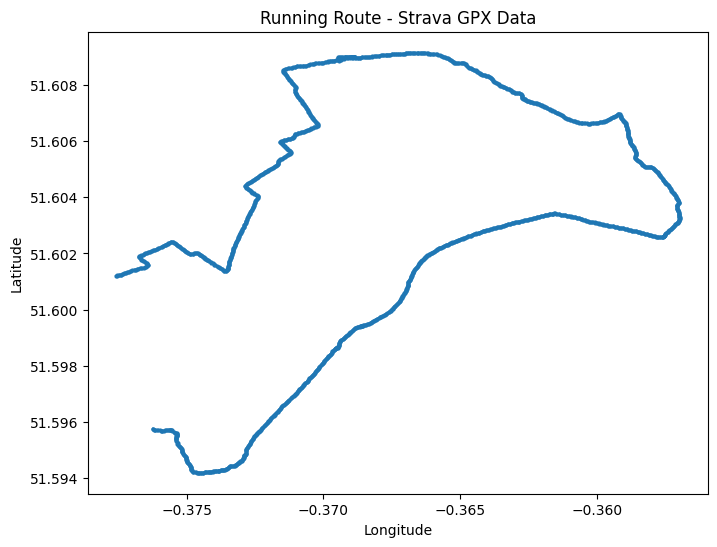

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(df["Longitude"], df["Latitude"], marker="o", linestyle="-", markersize=2)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Running Route - Strava GPX Data")
plt.show()


In [39]:
#loop through all gpx files for exeter only
# Selected dates of exeter runs: 

import os
import xml.etree.ElementTree as ET
import pandas as pd
from geopy.distance import geodesic

# Folder with GPX files
gpx_folder = "skye_strava_data/activities"

# Empty list to store run summaries
summary_data = []

# Namespace for parsing
ns = {"default": "http://www.topografix.com/GPX/1/1"}

# Loop through files
for filename in os.listdir(gpx_folder):
    if filename.endswith(".gpx"):
        file_path = os.path.join(gpx_folder, filename)
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Get run name
        name = root.find(".//default:name", ns).text

        # Get date
        date = root.find(".//default:time", ns).text[:10]

        # Extract points
        points = []
        times = []
        for trkpt in root.findall(".//default:trkpt", ns):
            lat = float(trkpt.get("lat"))
            lon = float(trkpt.get("lon"))
            time = trkpt.find("default:time", ns).text
            points.append((lat, lon))
            times.append(pd.to_datetime(time))

        # Calculate distance
        distance = 0
        for i in range(1, len(points)):
            distance += geodesic(points[i-1], points[i]).km

        # Calculate duration (minutes)
        duration = (times[-1] - times[0]).total_seconds() / 60

        # Calculate average pace
        avg_pace = duration / distance if distance > 0 else 0
        pace_str = f"{int(avg_pace)}:{int((avg_pace % 1) * 60):02d}"

        # Add to list
        summary_data.append({
            "Name": name,
            "Date": date,
            "Distance (km)": round(distance, 2),
            "Duration (min)": round(duration, 1),
            "Avg Pace (min/km)": pace_str
        })

# Create DataFrame
df_summary = pd.DataFrame(summary_data)

# Display
print(df_summary)

# Save to CSV
df_summary.to_csv("strava_run_summary.csv", index=False)


                     Name        Date  Distance (km)  Duration (min)  \
0                  2nd 5k  2024-08-10           5.03            30.4   
1     sheffield river run  2024-08-15           5.72            43.6   
2               a bit wet  2024-08-24           5.02            28.8   
3        easy cali warmup  2024-08-25           1.76            11.9   
4                with dad  2024-08-26           5.02            31.8   
5   bloody boiling ft dad  2024-09-01           6.62            43.0   
6    wakehams hill sprint  2024-09-03           0.22             1.1   
7         run to climbing  2024-09-15           2.82            15.8   
8      uni girls run club  2024-09-19           4.12            29.1   
9           Afternoon Run  2024-10-01           5.02            27.1   
10              Lunch Run  2024-10-03           1.98            11.5   
11       wet run to shops  2024-10-08           1.14             5.7   
12  illness can’t stop me  2024-10-12           5.75            

PermissionError: [Errno 13] Permission denied: 'strava_run_summary.csv'

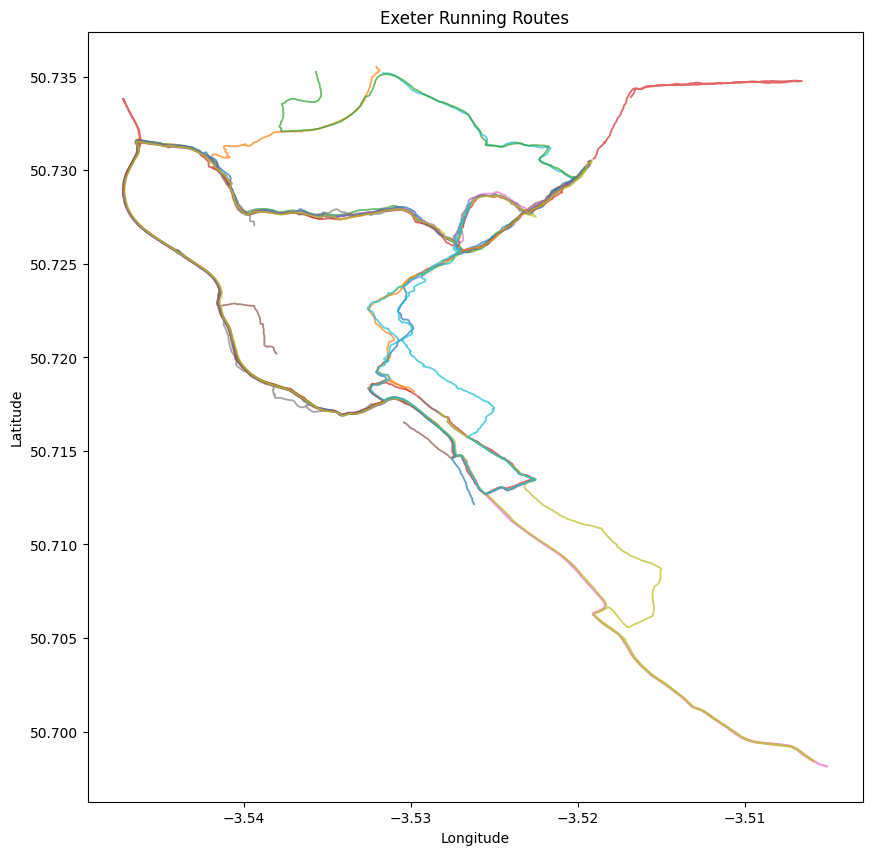

In [48]:

# GPX folder
gpx_folder = "skye_strava_data/activities"

# List of target dates - runs in exeter 
target_dates = [
    "2024-09-09", "2024-09-15", "2024-09-19", "2024-10-01", "2024-10-03", "2024-10-08", "2024-10-12",
    "2024-10-17", "2024-10-22", "2024-11-05", "2024-11-06", "2024-11-14", "2024-11-22", "2024-11-28",
    "2025-01-14", "2024-01-18", "2024-02-18", "2024-02-20", "2024-03-04", "2025-03-05", "2025-03-08",
    "2025-03-18", "2025-03-22", "2025-03-25"
]

# Namespace
ns = {"default": "http://www.topografix.com/GPX/1/1"}

# Plot setup
plt.figure(figsize=(10, 10))
plt.title("Exeter Running Routes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Loop over files
for filename in os.listdir(gpx_folder):
    if filename.endswith(".gpx"):
        file_path = os.path.join(gpx_folder, filename)
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Get date
        date_tag = root.find(".//default:time", ns)
        if date_tag is None:
            continue  # Skip if no date
        date = date_tag.text[:10]

        if date in target_dates:
            # Extract points
            lats = []
            lons = []
            for trkpt in root.findall(".//default:trkpt", ns):
                lat = float(trkpt.get("lat"))
                lon = float(trkpt.get("lon"))
                lats.append(lat)
                lons.append(lon)

            # Plot
            plt.plot(lons, lats, alpha=0.7, linewidth=1.3, label=date)


plt.show()


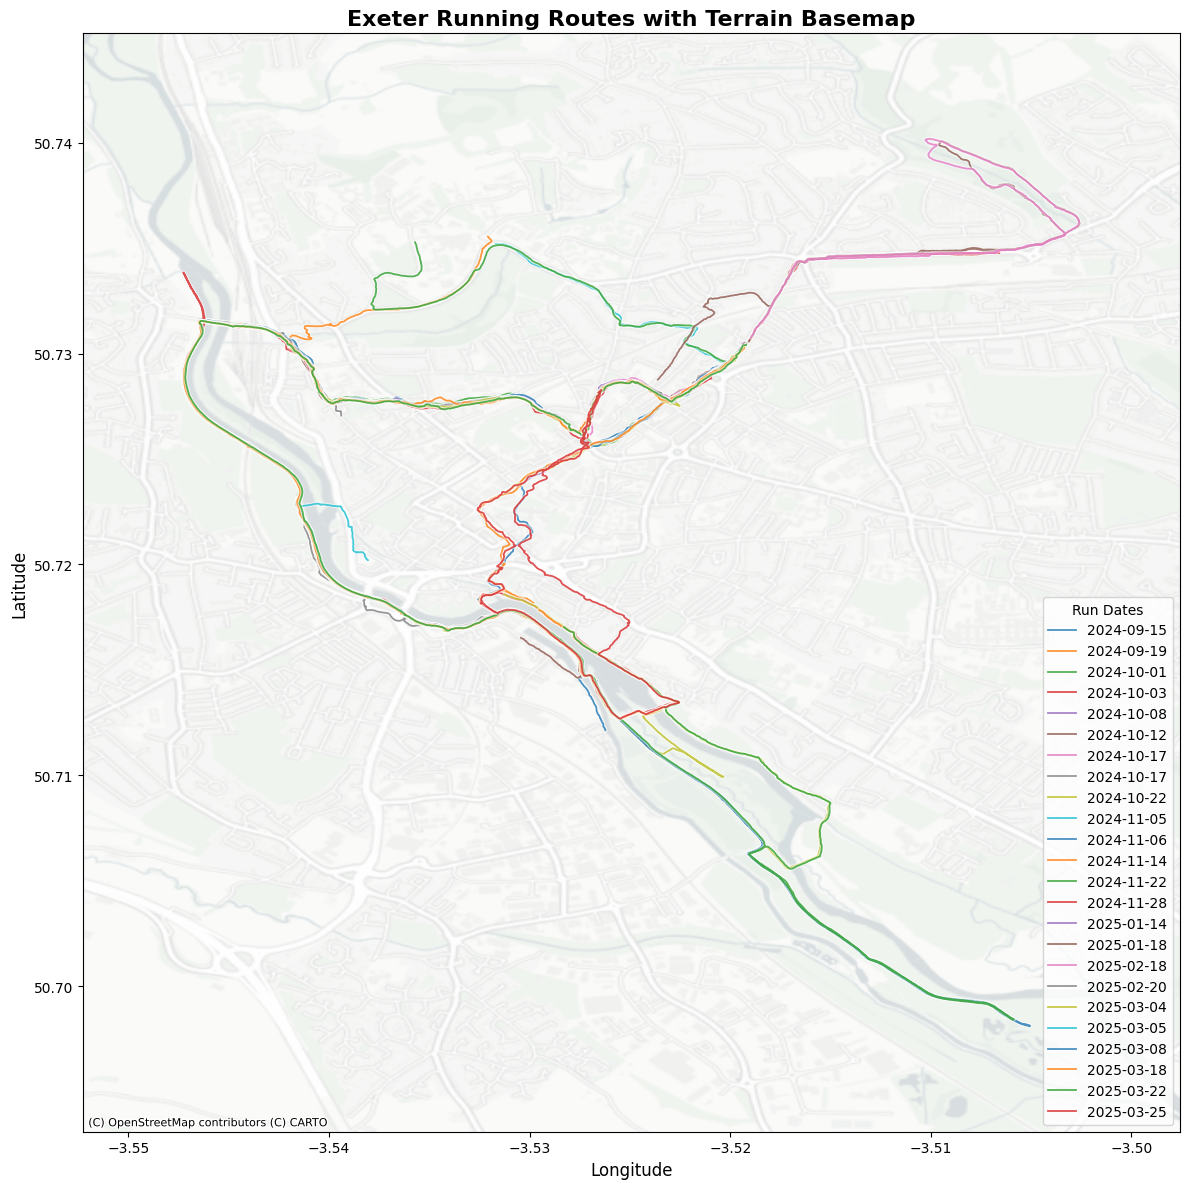

In [61]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import contextily as ctx

# GPX folder
gpx_folder = "skye_strava_data/activities"

# Target dates (Exeter runs)
target_dates = [
    "2024-09-09", "2024-09-15", "2024-09-19", "2024-10-01", "2024-10-03", "2024-10-08", "2024-10-12",
    "2024-10-17", "2024-10-22", "2024-11-05", "2024-11-06", "2024-11-14", "2024-11-22", "2024-11-28",
    "2025-01-14", "2025-01-18", "2025-02-18", "2025-02-20", "2025-03-04", "2025-03-05", "2025-03-08",
    "2025-03-18", "2025-03-22", "2025-03-25"
]

# Namespace
ns = {"default": "http://www.topografix.com/GPX/1/1"}

# Store all route coordinates
all_lats = []
all_lons = []

# Set up the plot
plt.figure(figsize=(12, 12))

# Loop over files
for filename in os.listdir(gpx_folder):
    if filename.endswith(".gpx"):
        file_path = os.path.join(gpx_folder, filename)
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Get date
        date_tag = root.find(".//default:time", ns)
        if date_tag is None:
            continue
        date = date_tag.text[:10]

        if date in target_dates:
            lats = []
            lons = []
            for trkpt in root.findall(".//default:trkpt", ns):
                lat = float(trkpt.get("lat"))
                lon = float(trkpt.get("lon"))
                lats.append(lat)
                lons.append(lon)

            # Plot each route with bold colors and outline
            plt.plot(lons, lats, color="white", linewidth=3, alpha=0.5)  # Outline (halo)
            plt.plot(lons, lats, linewidth=1.3, label=date, alpha=0.8)  # Main route

            all_lats.extend(lats)
            all_lons.extend(lons)

# Basemap - Grayscale map
if all_lats and all_lons:
    xmin, xmax = min(all_lons), max(all_lons)
    ymin, ymax = min(all_lats), max(all_lats)

    plt.xlim(xmin - 0.005, xmax + 0.005)  # Add a bit of padding
    plt.ylim(ymin - 0.005, ymax + 0.005)

    ax = plt.gca()
    ctx.add_basemap(
        ax,
        crs="EPSG:4326",
        source=ctx.providers.CartoDB.PositronNoLabels,  # Grayscale map
        alpha=0.9  # Slight transparency to make lines stand out
    )

# Labels and title
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.title("Exeter Running Routes with Terrain Basemap", fontsize=16, fontweight='bold')

# Add legend
plt.legend(fontsize=10, loc="lower right", title="Run Dates")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()




In [15]:
!pip install folium


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\leath\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


In [18]:
df.to_csv("processed_run_dataTEST.csv", index=False)

In [33]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Load your processed GPX data
df = pd.read_csv("processed_run_dataTEST.csv")  # Ensure it contains 'Latitude', 'Longitude', 'Speed (m/s)'

# Normalize speed values (avoid extreme values affecting heatmap)
df["Speed (m/s)"] = df["Speed (m/s)"].fillna(0)  # Handle NaNs
df["Speed (m/s)"] = df["Speed (m/s)"] / df["Speed (m/s)"].max()  # Normalize between 0 and 1

# Create a base map centered around the average location
m = folium.Map(location=[df["Latitude"].mean(), df["Longitude"].mean()], zoom_start=15)

# Convert latitude, longitude, and speed into a list of tuples for HeatMap
heat_data = list(zip(df["Latitude"], df["Longitude"], df["Speed (m/s)"]))

# Add heatmap layer where intensity = speed
HeatMap(heat_data, radius=9, blur=8, max_zoom=1).add_to(m)

# Save map as an HTML file and display it
m.save("speed_heatmap.html")
m


In [ ]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Load your processed GPX data
df = pd.read_csv("processed_run_dataTEST.csv")  # Ensure it contains 'Latitude', 'Longitude', 'Speed (m/s)'

# Normalize speed values (avoid extreme values affecting heatmap)
df["Speed (m/s)"] = df["Speed (m/s)"].fillna(0)  # Handle NaNs
df["Speed (m/s)"] = df["Speed (m/s)"] / df["Speed (m/s)"].max()  # Normalize between 0 and 1

# Create a base map centered around the average location
m = folium.Map(location=[df["Latitude"].mean(), df["Longitude"].mean()], zoom_start=15)

# Convert latitude, longitude, and speed into a list of tuples for HeatMap
heat_data = list(zip(df["Latitude"], df["Longitude"], df["Speed (m/s)"]))

# Add heatmap layer where intensity = speed
HeatMap(heat_data, radius=9, blur=8, max_zoom=1).add_to(m)

# Save map as an HTML file and display it
m.save("speed_heatmap.html")
m


In [ ]:
import folium
from folium.plugins import HeatMap
import pandas as pd

# Load your processed GPX data
df = pd.read_csv("processed_run_dataTEST.csv")  # Ensure it contains 'Latitude', 'Longitude', 'Speed (m/s)'

# Normalize speed values (avoid extreme values affecting heatmap)
df["Speed (m/s)"] = df["Speed (m/s)"].fillna(0)  # Handle NaNs
df["Speed (m/s)"] = df["Speed (m/s)"] / df["Speed (m/s)"].max()  # Normalize between 0 and 1

# Create a base map centered around the average location
m = folium.Map(location=[df["Latitude"].mean(), df["Longitude"].mean()], zoom_start=15)

# Convert latitude, longitude, and speed into a list of tuples for HeatMap
heat_data = list(zip(df["Latitude"], df["Longitude"], df["Speed (m/s)"]))

# Add heatmap layer where intensity = speed
HeatMap(heat_data, radius=9, blur=8, max_zoom=1).add_to(m)

# Save map as an HTML file and display it
m.save("speed_heatmap.html")
m
